In [1]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). Please, ensure the directory exists and can be written to.
There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.
Matplotlib created a temporary cache directory at /tmp/matplotlib-5dl9ojyn because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
DATA_PATH = "/mydata/chip/luisb/mice_brain/" if torch.cuda.is_available() else "data"
integer_brain_coord = torch.tensor(np.load(f'{DATA_PATH}/integer_brain_coord.npy'))
reference_image = torch.tensor(np.load(f'{DATA_PATH}/reference_image.npy').astype(np.int16))
brain2_slices_rs = torch.tensor(np.load(f'{DATA_PATH}/brain2_slices_rs.npy'))
brain2_slices_rs, reference_image, integer_brain_coord

(tensor[1918708, 156] f64 n=299318448 (2.2Gb) x∈[-0.692, 12.450] μ=-7.468e-17 σ=1.000,
 tensor[528, 320, 456] i16 n=77045760 (0.1Gb) x∈[0, 516] μ=59.817 σ=78.802,
 tensor[1918708, 3] i64 n=5756124 (44Mb) x∈[9, 515] μ=237.173 σ=114.511)

In [3]:
# notmalize data
# normalize volume
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
means, stds

(tensor[157] x∈[-0.272, 109.213] μ=0.696 σ=8.744,
 tensor[157] x∈[0.084, 83.133] μ=0.788 σ=6.627)

In [4]:
reference_image = (reference_image - means[-1]) / stds[-1]
brain2_slices_rs = (brain2_slices_rs - means[:-1]) / stds[:-1]
brain2_slices_rs, reference_image

(tensor[1918708, 156] f64 n=299318448 (2.2Gb) x∈[-7.406, 97.790] μ=-0.307 σ=0.941,
 tensor[528, 320, 456] n=77045760 (0.3Gb) x∈[-1.314, 4.893] μ=-0.594 σ=0.948)

# Dataset

In [5]:
import sys
import os

from argparse import ArgumentParser

import torch
from pytorch_base.experiment import PyTorchExperiment
from pytorch_base.base_loss import BaseLoss

import random
from tqdm.auto import tqdm

from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

import numpy as np
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import lovely_tensors as lt
lt.monkey_patch()


In [6]:
def apply_circle_mask(img):
    W, H = img.shape[-2:]
    cp = torch.cartesian_prod(torch.arange(W, device=img.device), torch.arange(H, device=img.device))
    circle_mask = (cp[:, 0] - W / 2) ** 2 + (cp[:, 1] - W / 2) ** 2 <= (W / 2) ** 2
    return img * circle_mask.reshape(img.shape[-2:])

In [7]:
from mice.datasets.slice_dataset import SliceDataset
import lovely_tensors as lt
import os
lt.monkey_patch()


means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))


kwargs = {
    'path': f'{DATA_PATH}/sections',
    'im_size':32,
    'train_transform': True,
#     'rotation_angle': 30,
#     'rescale': 100,
    'stds':stds,
    'means':means
}

trainSet = SliceDataset(**kwargs)
print(trainSet[100])

tensor[2, 157, 32] n=10048 (39Kb) x∈[-1.895, 9.520] μ=-0.246 σ=0.573


# Testing Diffussion model

In [8]:
from diffusers import UNet1DModel
from main import load_model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')
model = UNet1DModel(
        sample_size=32,  # Adjusted to 32
        in_channels=11,
        out_channels=11,
        layers_per_block=1,
        block_out_channels=(32, 64),  # Reduced the number of output channels per block
        down_block_types=(
            "DownBlock1D",  # Keep the same
            "AttnDownBlock1D",  # One less downsampling block
        ),
        up_block_types=(
            "AttnUpBlock1D",  # Keep the same
            "UpBlock1D",  # Reduced the number of upsampling blocks accordingly
        ),
    ).to(device)
load_model(model, "checkpoints/MiceBrain10.pt")
# model.eval()
""

models loaded from checkpoint checkpoints/MiceBrain10.pt


''

tensor[1, 11, 32] n=352 (1.4Kb) x∈[-1.340, 1.869] μ=-0.209 σ=0.623

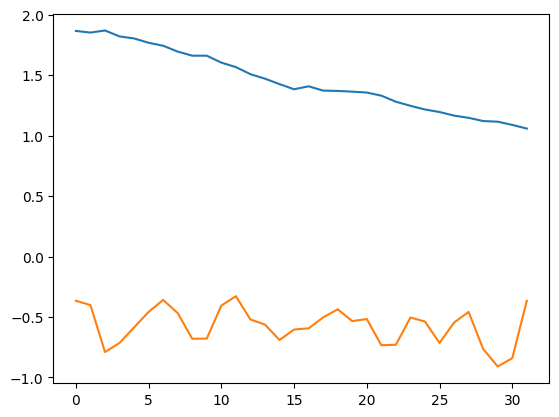

In [9]:
# load dataset
from main import get_dataset
means = torch.tensor(np.load("means.npy"))
stds = torch.tensor(np.load("stds.npy"))
kwargs = {
    "path": f"{DATA_PATH}/sections",
    'im_size':32,
    "train_transform": True,
    'stds': stds,
    'means': means
}

trainSet, testSet = get_dataset(kwargs)
target = testSet[0][:1, -11:]
plt.plot(target[0, -1])
plt.plot(target[0, 8])
target

# Testing diffusion on one sample

In [10]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.config.clip_sample = True
noise_scheduler.config.clip_sample_range = 5.0

timestep = torch.LongTensor([500]).to(device)
noise = torch.randn_like(target[:, 0]).to(device)
expanded_noise = noise.repeat(target.shape[1], 1, 1).transpose(0, 1)
x_t = noise_scheduler.add_noise(target.to(device), expanded_noise, timestep).to(device)

# we predict the noise for this step t
with torch.no_grad():
    x_0_pred = model(x_t, timestep=timestep, return_dict=False)[0]
    
#     fading_factor = noise_scheduler.add_noise(torch.ones(1), torch.zeros(1), timestep).to(device)
#     noise_factor = noise_scheduler.add_noise(torch.zeros(1), torch.ones(1), timestep).to(device)

#     x_0_pred = (x_t - noise_factor * noise_pred) / fading_factor
#     x_0_pred = noise_scheduler.step(noise_pred.repeat(target.shape[1], 1, 1).transpose(0, 1), timestep.item(), x_t).pred_original_sample


# plot_tomogram_overview(x_0_pred[0].cpu().detach().clip(0, 1))
mse = torch.nn.MSELoss()
loss = mse(x_0_pred, target.to(device))
loss

tensor cuda:0 0.026

In [11]:
import torch.nn.functional as F
padded_reference = F.pad(reference_image, (0, 24, 0, 0, 0, 16))
padded_reference

tensor[544, 320, 480] n=83558400 (0.3Gb) x∈[-1.314, 4.893] μ=-0.548 σ=0.924

In [12]:
indices = torch.arange(156-10, 156)
with torch.no_grad():
    volume = torch.zeros((*padded_reference.shape, len(indices)+1), dtype=torch.float32)
    volume[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2], :-1] =  brain2_slices_rs[:, indices].clone().float()
    volume[:, :, :, -1] = padded_reference
volume

tensor[544, 320, 480, 11] n=919142400 (3.4Gb) x∈[-5.241, 97.790] μ=-0.056 σ=0.348

In [13]:
def flatten(permutation, volume, size=32):
    return volume.permute(permutation).flatten(0, 1).unfold(dimension=1, size=size, step=size).flatten(0, 1)

def unflatten(permutation, flat_volume, shape):
    size = flat_volume.shape[-1]
    permuted_shape = [shape[i] for i in permutation]
    inverse_permutation = [x.item() for x in torch.tensor(permutation).sort().indices]
    unfolded_volume = flat_volume.unflatten(0, (-1, permuted_shape[-2]//size)).transpose(-1, -2).flatten(-3, -2)
    return unfolded_volume.reshape(permuted_shape, 2).permute(inverse_permutation)

permutation = (2, 1, 0, 3)
unflatten(permutation,  flatten(permutation, volume), volume.shape) - volume

tensor[544, 320, 480, 11] n=919142400 (3.4Gb) all_zeros

In [14]:
import torch.nn as nn
class BrainSliceDiffusion(nn.Module):
    def __init__(self, image_shape, channels_indices, unet, buffer=5):
        super(BrainSliceDiffusion, self).__init__()
        self.unet = unet
        self.buffer = buffer
        self.channels = channels_indices

    def inpainting(self, pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image):
        with torch.no_grad():
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2], :-1] *= 0
            pred_x_0[integer_brain_coord[:, 0], integer_brain_coord[:, 1], integer_brain_coord[:, 2], :-1] +=  brain2_slices_rs[:, self.channels].clone().float() 
            pred_x_0[:, :, :, -1] *= 0
            pred_x_0[:, :, :, -1] += reference_image
        return pred_x_0

    def predict_x_0(self, t, x_t, noise_scheduler):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        timesteps = torch.LongTensor([t]).to(device)
        x_0_pred = self.unet(x_t.to(device), timesteps.to(device), return_dict=False)[0]
        return x_0_pred.cpu()

    def step(self, t, target_t, x_t, noise_scheduler):
        x_0_pred = self.predict_x_0(t, x_t, noise_scheduler)
        new_timestep = torch.LongTensor([target_t]).to(device)
        new_x_t = noise_scheduler.add_noise(x_0_pred, torch.randn_like(x_0_pred), new_timestep).to(device)

        return new_x_t, noise_pred

    def diffusion_pipeline(self, x_t_start, t_start, t_end, noise_scheduler, num_steps=50, verbose=False):
        with torch.no_grad():
            x_t = x_t_start.clone()

            timesteps = torch.linspace(t_start, t_end, num_steps + 1).int()
            for i in tqdm(range(1, len(timesteps)), disable=not verbose):
                t = timesteps[i - 1]
                target_t = timesteps[i]
                x_t, _ = self.step(t, target_t, x_t, noise_scheduler)
            return x_t

    def guided_diffusion_pipeline(
        self, x_t_start, t_start, t_end, noise_scheduler, num_steps,
        integer_brain_coord, brain2_slices_rs, reference_image,
        batch_size, verbose=True
    ):
        x_t = x_t_start.clone()

        timesteps = torch.linspace(t_start, t_end + self.buffer, num_steps + 1).int()
        iterator = tqdm(range(1, len(timesteps)))
        for i in iterator:
            t = timesteps[i - 1]
            target_t = timesteps[i]
            permutations = [
                [0, 1, 2, 3],
                [1, 2, 0, 3],
                [2, 0, 1, 3]
            ]
            with torch.no_grad():
                permutation = permutations[i % len(permutations)]
                axial_batches = flatten(permutation, x_t)
                pred_x_0 = torch.zeros_like(axial_batches)
                assert(len(axial_batches) % batch_size == 0)
                for j, x_t_batch in enumerate(axial_batches.unfold(dimension=0, size=batch_size, step=batch_size).permute(0, 3, 1, 2)):
                    pred_x_0[j * batch_size: (j+1) * batch_size] = self.predict_x_0(t, x_t_batch, noise_scheduler)
                    iterator.set_postfix({"state": f"running batch {j}"})
                    
                iterator.set_postfix({"state": f"starting unflattening"})
                pred_x_0 = unflatten(permutation, pred_x_0, x_t.shape)
                del axial_batches
                
            pred_x_0 = self.inpainting(pred_x_0, integer_brain_coord, brain2_slices_rs, reference_image)

            new_timestep = torch.LongTensor([target_t]).to(device)
            x_t = noise_scheduler.add_noise(pred_x_0, torch.randn_like(pred_x_0), new_timestep)


#         x_t = self.diffusion_pipeline(
#             x_t, t_end + self.buffer, t_end,
#             noise_scheduler, num_steps=self.buffer,
#             verbose=verbose
#         )

        return x_t


In [ ]:
from tqdm.auto import tqdm
T = torch.LongTensor([999])
noise = torch.randn_like(volume)
x_T = noise_scheduler.add_noise(volume, noise, T).cpu()

bsd = BrainSliceDiffusion(volume.shape, channels_indices=torch.arange(-10, 0), unet=model)

res = bsd.guided_diffusion_pipeline(
    x_t_start = x_T, t_start=999, t_end=0, noise_scheduler=noise_scheduler, num_steps=50,
    integer_brain_coord=integer_brain_coord, brain2_slices_rs=brain2_slices_rs, reference_image=padded_reference,
    batch_size=2400, verbose = True
)

  6% 3/50 [08:04<1:49:01, 139.19s/it, state=running batch 517]    

In [ ]:
np.save("mice_recons", res.cpu().detach().numpy())

In [ ]:
plt.imshow(res[:, :, :, -1][:, 130].cpu())

In [ ]:
plt.plot(res[303, :, 200])